GATech Colors

Gold - RGB - 133, 116, 55
B3A369

Navy - RGB – 23, 21, 67
003057

Grey - RGB – 214, 219, 212
D6DBD4

Dark Gray RGB - 84, 88, 90
54585A

Light Yellow RGB - 255, 210, 89
FFD259

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'DejaVu Sans'

In [77]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, oil_temperature, dv_electric 
        from train_data 
        where '2022-01-05 06:00:00' <= ts and date(ts) < '2022-01-06'
    """, con=con, parse_dates=['ts'])

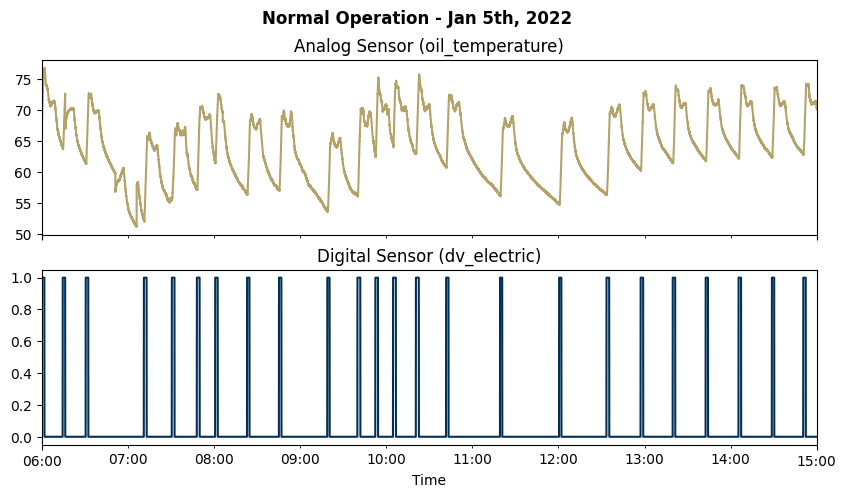

In [78]:
ax = df.head(int(df.shape[0]/2) + 1).plot(
    x='ts', 
    y=['oil_temperature', 'dv_electric'], 
    subplots=True, 
    figsize=(10, 5), 
    legend=False,
    color=['#B3A369', '#003057']
);

ax[0].set_title('Analog Sensor (oil_temperature)')
ax[1].set_title('Digital Sensor (dv_electric)')
ax[1].set_xlabel('Time')

plt.suptitle('Normal Operation - Jan 5th, 2022', fontweight='bold')
plt.show()

In [85]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, oil_temperature, dv_electric 
        from train_data 
        where '2022-02-28 06:00:00' <= ts and ts < '2022-03-01 00:00:00'
    """, con=con, parse_dates=['ts'])

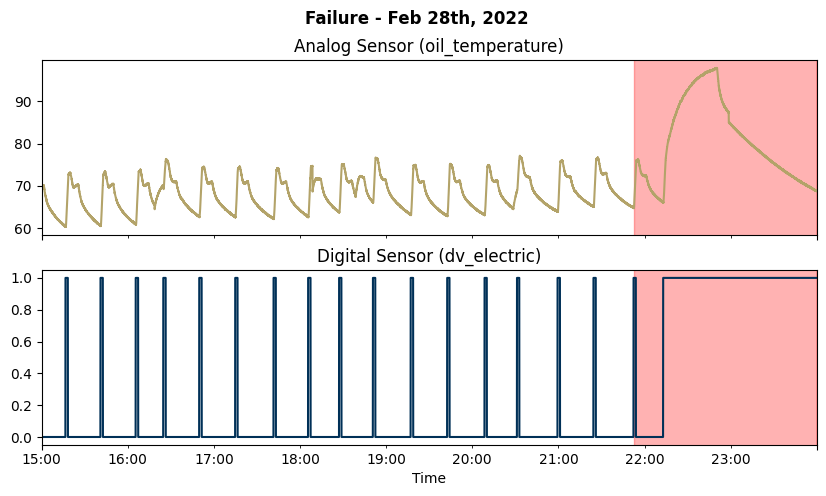

In [87]:
axes = df.tail(int(df.shape[0]/2) + 1).plot(
    x='ts', 
    y=['oil_temperature', 'dv_electric'], 
    subplots=True, 
    figsize=(10, 5), 
    legend=False,
    color=['#B3A369', '#003057']
);

axes[0].set_title('Analog Sensor (oil_temperature)')
axes[1].set_title('Digital Sensor (dv_electric)')
axes[1].set_xlabel('Time')

for ax in axes:
    ax.autoscale(False)
    ax.fill_between(
        df['ts'].to_list(),
        100,
        -100,
        where=(df['failure_id'] == 1).to_list(),
        color='red',
        alpha=0.3
    )

plt.suptitle('Failure - Feb 28th, 2022', fontweight='bold')
plt.show()

In [2]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select 
            t.ts
            ,t.failure_id
            
            ,t.oil_temperature -- Signals to plot
            ,t.reservoirs
                     
            ,r.puv_pred
            ,r.puv_pred_filtered -- Aggregated PUV preds
            
            ,p.yhat_lower
            ,p.yhat_upper
            ,p.yhat_lower_expanded -- oil_temperature bounds for plotting
            ,p.yhat_upper_expanded

            ,r.pmv_pred
            ,r.pmv_pred_filtered -- pred coming from reservoirs_mv
                     
            ,rmv.yhat_lower as rmv_yhat_lower
            ,rmv.yhat_upper as rmv_yhat_upper
            ,rmv.yhat_lower_expanded as rmv_yhat_lower_expanded -- reservoirs_mv bounds for plotting
            ,rmv.yhat_upper_expanded as rmv_yhat_upper_expanded
                     
            ,r.pmv_multi_pred
            ,r.pmv_multi_pred_filtered -- Aggregated PUV preds
            
            ,pmv.yhat_lower as yhat_lower_multi
            ,pmv.yhat_upper as yhat_upper_multi
            ,pmv.yhat_lower_expanded as yhat_lower_expanded_multi
            ,pmv.yhat_upper_expanded as yhat_upper_expanded_multi
            
        from train_data as t
                     
            left join consolidated_results as r
                on r.ts = t.ts
                     
            left join prophet_results as p
                on  p.ds = t.ts
                and p.col = 'oil_temperature'
                     
            left join prophet_results_mv_multi as pmv
                on  pmv.ds = t.ts
                and pmv.col = 'oil_temperature'
                     
            left join prophet_results as rmv
                on  rmv.ds = t.ts
                and rmv.col = 'reservoirs_mv'
                     
        where '2022-02-27 06:00:00' <= t.ts and t.ts < '2022-03-01 00:00:00'
    """, con=con, parse_dates=['ts'])

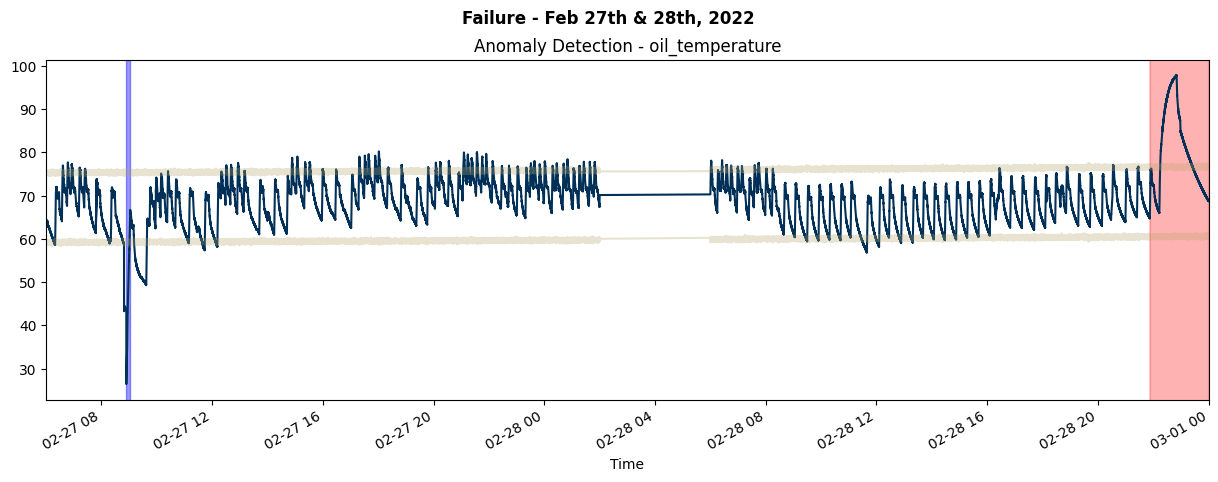

In [9]:
ax = df.plot(
    x='ts', 
    y=['oil_temperature', 'yhat_lower_expanded', 'yhat_upper_expanded'],
    figsize=(15, 5),
    color=['#003057', '#B3A369', '#B3A369'],
    legend=False
);
ax.set_title('Anomaly Detection - oil_temperature')
ax.set_xlabel('Time')

for line, alpha in zip(ax.lines, [1., 0.3, 0.3]):
    line.set_alpha(alpha)


ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlim('2022-02-27 06:00:00', '2022-03-01 00:00:00')

ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=(df['failure_id'] == 1).to_list(),
    color='red',
    alpha=0.3
)
ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=((df['puv_pred_filtered'] == 1) & (df['failure_id'] != 1)).to_list(),
    color='blue',
    alpha=0.4
)

plt.suptitle('Failure - Feb 27th & 28th, 2022', fontweight='bold')
plt.show()

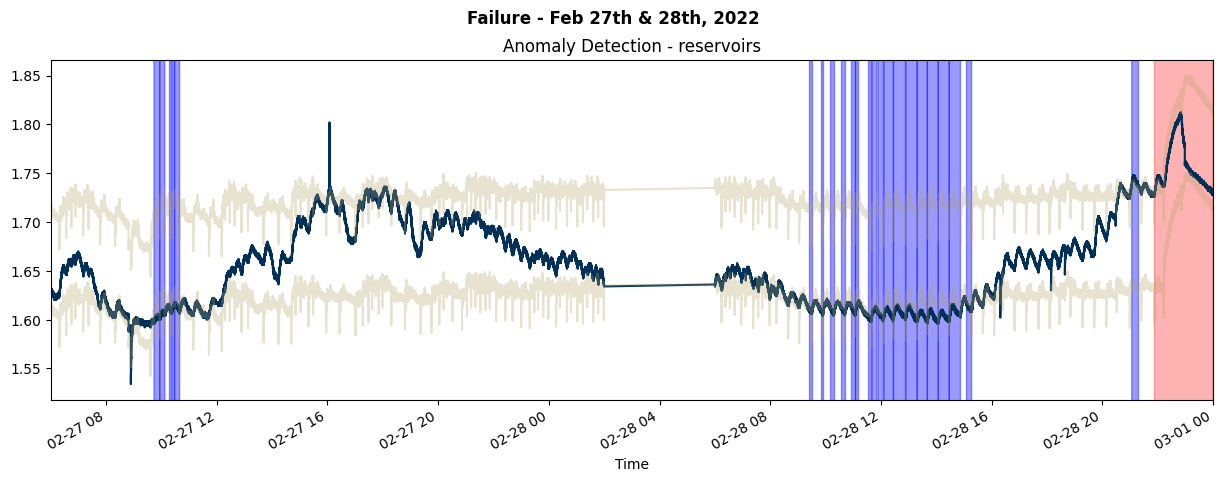

In [128]:
ax = df.plot(
    x='ts', 
    y=['reservoirs', 'rmv_yhat_lower_expanded', 'rmv_yhat_upper_expanded'],
    figsize=(15, 5),
    color=['#003057', '#B3A369', '#B3A369'],
    legend=False
);
ax.set_title('Anomaly Detection - reservoirs')
ax.set_xlabel('Time')

for line, alpha in zip(ax.lines, [1., 0.3, 0.3]):
    line.set_alpha(alpha)


ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlim('2022-02-27 06:00:00', '2022-03-01 00:00:00')

ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=(df['failure_id'] == 1).to_list(),
    color='red',
    alpha=0.3
)
ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=((df['pmv_pred_filtered'] == 1) & (df['failure_id'] != 1)).to_list(),
    color='blue',
    alpha=0.4
)

plt.suptitle('Failure - Feb 27th & 28th, 2022', fontweight='bold')
plt.show()

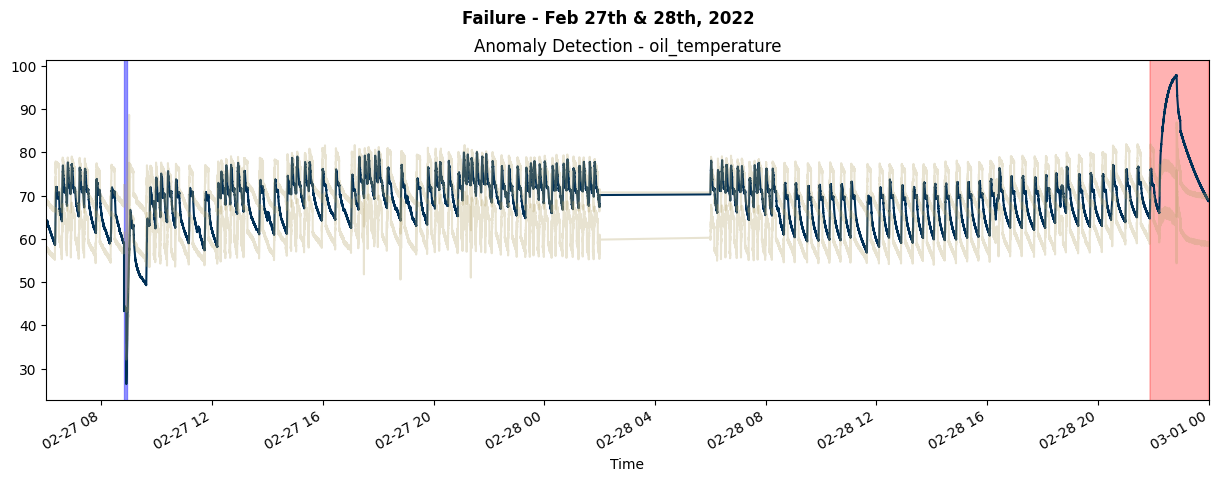

In [5]:
ax = df.plot(
    x='ts', 
    y=['oil_temperature', 'yhat_lower_expanded_multi', 'yhat_upper_expanded_multi'],
    figsize=(15, 5),
    color=['#003057', '#B3A369', '#B3A369'],
    legend=False
);
ax.set_title('Anomaly Detection - oil_temperature')
ax.set_xlabel('Time')

for line, alpha in zip(ax.lines, [1., 0.3, 0.3]):
    line.set_alpha(alpha)


ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)
ax.set_xlim('2022-02-27 06:00:00', '2022-03-01 00:00:00')

ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=(df['failure_id'] == 1).to_list(),
    color='red',
    alpha=0.3,
    label='Failure'
)
ax.fill_between(
    df['ts'].to_list(),
    200,
    -200,
    where=((df['pmv_multi_pred_filtered'] == 1) & (df['failure_id'] != 1)).to_list(),
    color='blue',
    alpha=0.4,
    label='Anomaly'
)

plt.suptitle('Failure - Feb 27th & 28th, 2022', fontweight='bold')
plt.show()